In [ ]:
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
!ls
!tar -xvf u-net-release.tar.gz

sample_data
tar: u-net-release.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [ ]:
!unzip /content/PPM-100 -d /content

Archive:  /content/PPM-100.zip
   creating: /content/PPM-100/
  inflating: /content/__MACOSX/._PPM-100  
   creating: /content/PPM-100/matte/
  inflating: /content/__MACOSX/PPM-100/._matte  
   creating: /content/PPM-100/image/
  inflating: /content/__MACOSX/PPM-100/._image  
  inflating: /content/PPM-100/matte/14429083354_23c8fddff5_o.jpg  
  inflating: /content/__MACOSX/PPM-100/matte/._14429083354_23c8fddff5_o.jpg  
  inflating: /content/PPM-100/matte/48624730818_67ff3c2811_o.jpg  
  inflating: /content/__MACOSX/PPM-100/matte/._48624730818_67ff3c2811_o.jpg  
  inflating: /content/PPM-100/matte/7085121445_1165c4a561_o.jpg  
  inflating: /content/__MACOSX/PPM-100/matte/._7085121445_1165c4a561_o.jpg  
  inflating: /content/PPM-100/matte/4065842143_71bd1d0b2f_o.jpg  
  inflating: /content/__MACOSX/PPM-100/matte/._4065842143_71bd1d0b2f_o.jpg  
  inflating: /content/PPM-100/matte/50048955706_7d520d5a19_o.jpg  
  inflating: /content/__MACOSX/PPM-100/matte/._50048955706_7d520d5a19_o.jpg  
  

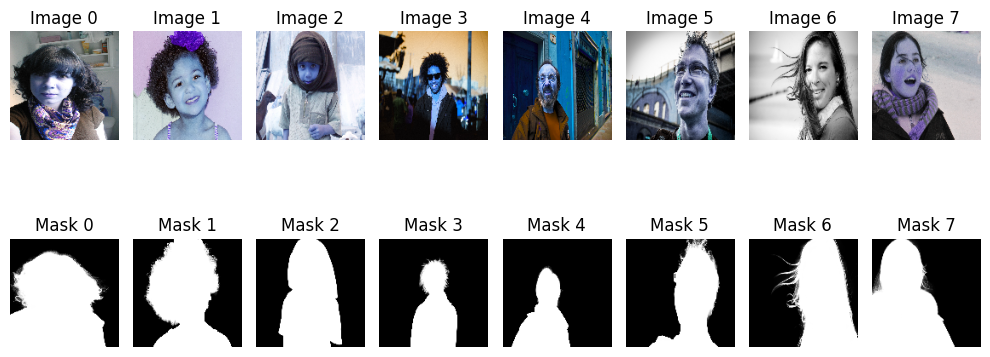

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf

class NucleiDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_ids, img_path, batch_size=8, image_size=128):
        self.ids = image_ids
        self.path = img_path
        self.batch_size = batch_size
        self.image_size = image_size

    def __load__(self, id_name):
        image_path = os.path.join(self.path, "image", id_name + ".jpg")
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (self.image_size, self.image_size))
        image = image / 255.0

        mask_path = os.path.join(self.path, "matte", id_name + ".jpg")
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (self.image_size, self.image_size))
        mask = mask / 255.0
        mask = np.expand_dims(mask, axis=-1)

        return image, mask

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.ids):
            batch_ids = self.ids[index * self.batch_size:]
        else:
            batch_ids = self.ids[index * self.batch_size : (index + 1) * self.batch_size]

        images = []
        masks = []

        for id_name in batch_ids:
            img, msk = self.__load__(id_name)
            images.append(img)
            masks.append(msk)

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.ids) / self.batch_size))

# Helper function to get image IDs
def get_image_ids(image_dir):
    return [os.path.splitext(file)[0] for file in os.listdir(image_dir) if file.endswith('.jpg')]

# Replace 'path_to_your_data' with the actual path to your 'image' and 'matte' folders
image_dir = os.path.join('/content/PPM-100', 'image')
image_ids = get_image_ids(image_dir)

# Initialize the data generator
data_gen = NucleiDataGenerator(image_ids=image_ids, img_path='/content/PPM-100')

# Fetch a batch for visualization (assuming that matplotlib is installed)
import matplotlib.pyplot as plt

images, masks = data_gen[0]  # Get the first batch
plt.figure(figsize=(10, 5))

for i in range(len(images)):
    plt.subplot(2, len(images), i+1)
    plt.imshow(images[i])
    plt.title(f"Image {i}")
    plt.axis('off')

    plt.subplot(2, len(images), i+1+len(images))
    plt.imshow(masks[i].squeeze(), cmap='gray')
    plt.title(f"Mask {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Example code to split image IDs into train and validation sets

# Get all image IDs
all_image_ids = get_image_ids(image_dir)  # Assuming image_dir is defined

total_images = len(all_image_ids)
train_size = int(0.8 * total_images)  # 80% for training
val_size = int(0.1 * total_images)  # 10% for validation

# Define the sets
train_ids = all_image_ids[:train_size]
valid_ids = all_image_ids[train_size:train_size + val_size]
test_ids = all_image_ids[train_size + val_size:]

# Make sure img_path is defined to point to the directory containing 'image' and 'matte'
img_path = '/content/PPM-100'  # Replace with your actual path
# print(len(train_ids))


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D

def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    # Contracting Path
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)


    # Expansive Path
    u6 = UpSampling2D((2, 2))(c2)
    u6 = concatenate([u6, c1], axis=3)
    c6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c6)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Create the model
model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Replace with your actual data and parameters
train_gen = NucleiDataGenerator(train_ids, img_path, batch_size=8, image_size=128)
valid_gen = NucleiDataGenerator(valid_ids, img_path, batch_size=8, image_size=128)
# print(train_gen, valid_gen)
model.fit(train_gen, validation_data=valid_gen, epochs=25)


Epoch 1/25
10/10 [==============================] - 28s 2s/step - loss: 0.7298 - accuracy: 0.5922 - val_loss: 0.5149 - val_accuracy: 0.7431
Epoch 2/25
10/10 [==============================] - 16s 2s/step - loss: 0.5519 - accuracy: 0.6964 - val_loss: 0.4936 - val_accuracy: 0.7045
Epoch 3/25
10/10 [==============================] - 18s 2s/step - loss: 0.5460 - accuracy: 0.7047 - val_loss: 0.5488 - val_accuracy: 0.6905
Epoch 4/25
10/10 [==============================] - 15s 2s/step - loss: 0.5376 - accuracy: 0.7178 - val_loss: 0.4854 - val_accuracy: 0.6823
Epoch 5/25
10/10 [==============================] - 18s 2s/step - loss: 0.5084 - accuracy: 0.7250 - val_loss: 0.4580 - val_accuracy: 0.6896
Epoch 6/25
10/10 [==============================] - 15s 2s/step - loss: 0.4866 - accuracy: 0.7388 - val_loss: 0.4605 - val_accuracy: 0.7093
Epoch 7/25
10/10 [==============================] - 15s 2s/step - loss: 0.5050 - accuracy: 0.7334 - val_loss: 0.5181 - val_accuracy: 0.7036
Epoch 8/25
10/10 [==

In [ ]:
test_gen = NucleiDataGenerator(test_ids, img_path, batch_size=1, image_size=128)
results = model.predict(test_gen)

10/10 [==============================] - 2s 135ms/step


In [ ]:
loss, accuracy = model.evaluate(test_gen)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

10/10 [==============================] - 2s 152ms/step - loss: 0.5419 - accuracy: 0.7159
Test Loss: 0.5419185757637024
Test Accuracy: 0.715893566608429


back.jpg  __MACOSX  PPM-100  PPM-100.zip  sample_data  u-net-release  u-net-release.tar.gz
Number of images: 8
Number of masks (results): 80


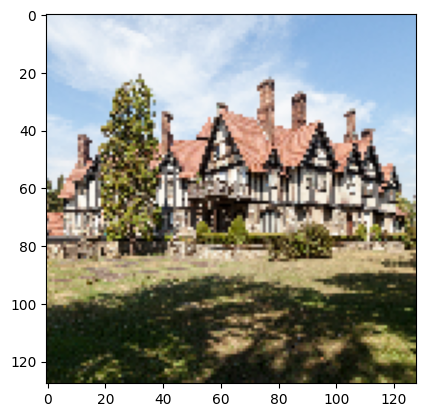

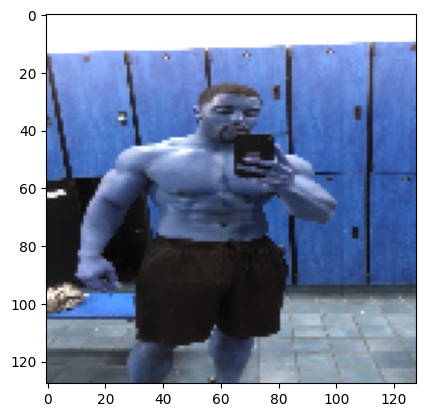

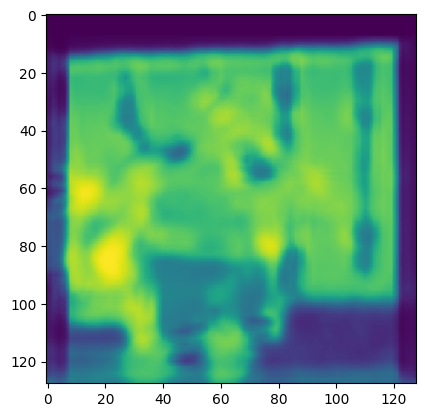

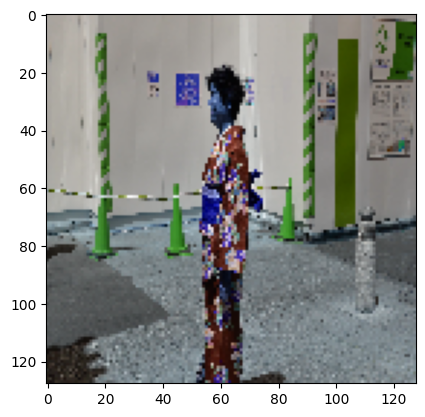

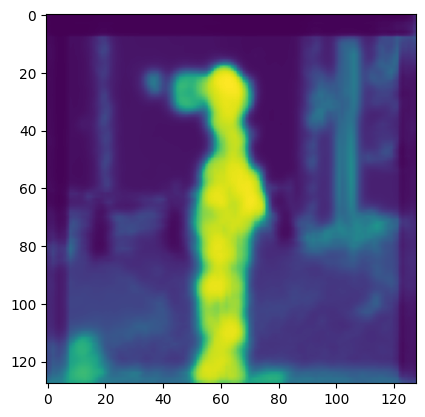

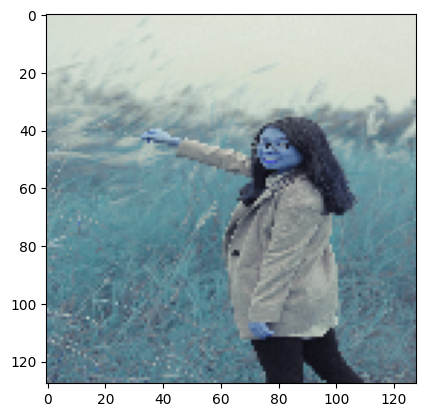

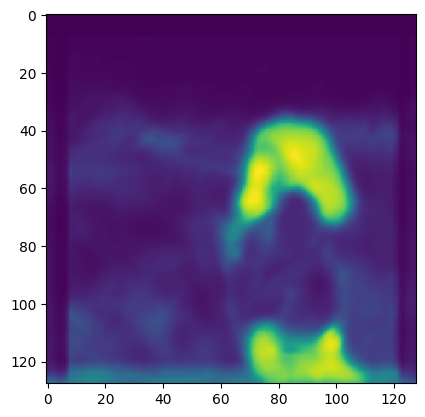

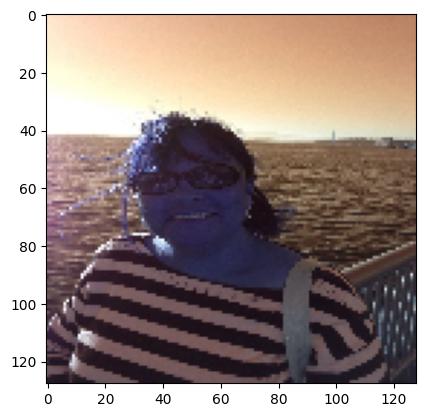

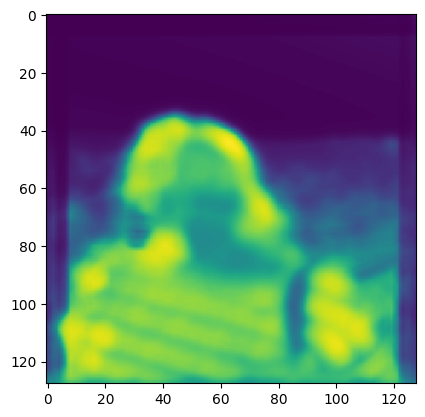

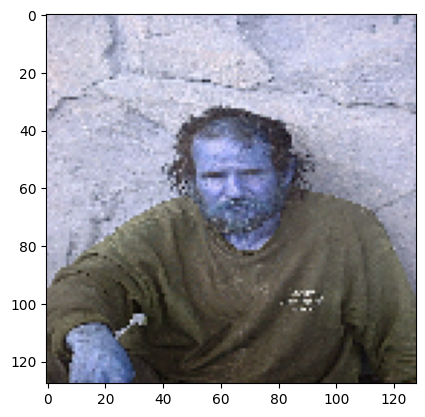

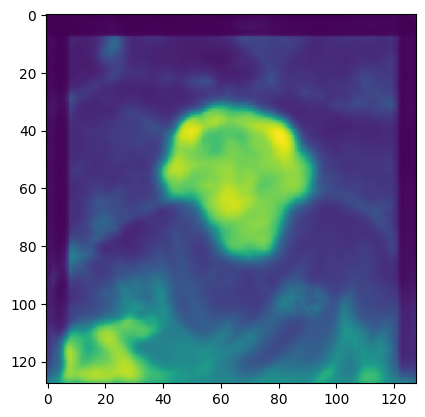

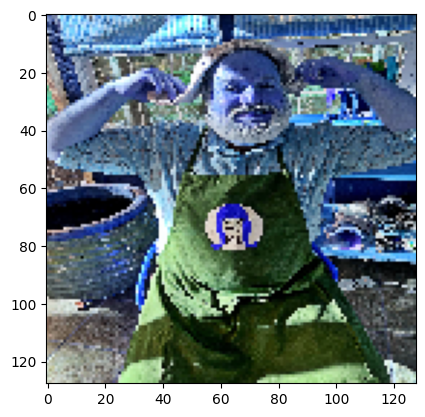

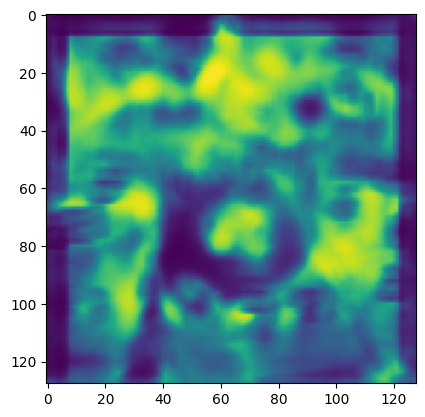

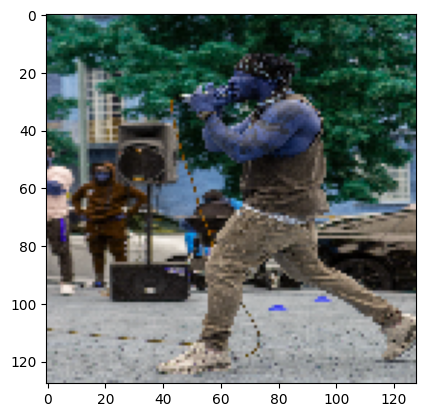

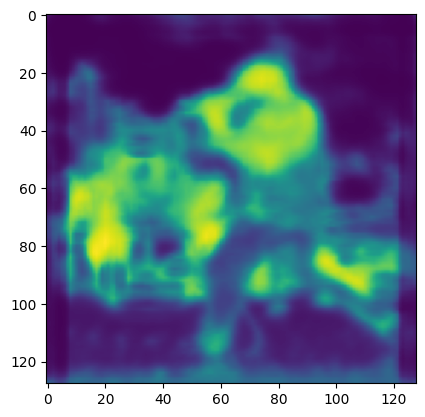

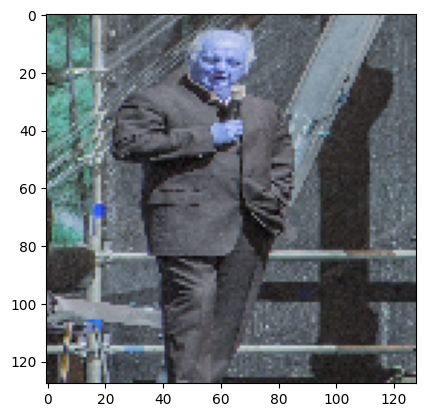

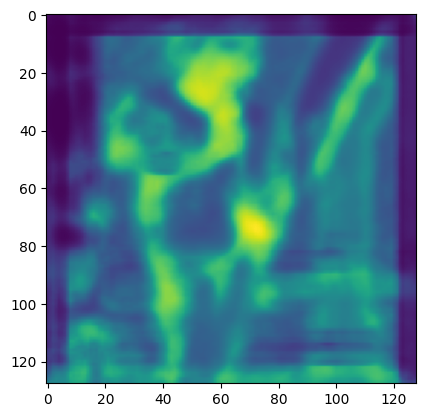

In [ ]:
def apply_mask(image, mask, background):
    object_pixels = image * mask
    background_pixels = background * (1 - mask)
    return object_pixels + background_pixels

# Assuming background is a numpy array of your chosen background image
# background = ... # Load or define your background image
!ls
background_path = '/content/back.jpg'
background = cv2.imread(background_path, cv2.IMREAD_COLOR)
background = cv2.resize(background, (128, 128))

# Convert color from BGR to RGB
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)

# Normalize the background if your images are normalized (values between 0 and 1)
background = background / 255.0
print("Number of images:", len(images))
print("Number of masks (results):", len(results))
plt.imshow(background)
plt.show()


# Assuming images is a batch of original images and results is the corresponding predicted masks
for i in range(len(images)):
    plt.imshow(images[i])
    plt.show()
    plt.imshow(results[i])
    plt.show()
    #final_image = apply_mask(images[i], results[i], background)
    #plt.imshow(final_image)
    #lt.show()
